## Hopfield算法（矩阵版本）

In [1341]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
class HopfieldTSP():
    def __init__(self,cities,A=300,D=100,iterations=5000):
        self.cities = cities
        self.n = cities.shape[0]
        self.u0 = 0.02
        self.delta_t = 1e-4
        self.A = 300
        self.D = 100
        self.iter = iterations
        self.W = np.zeros((self.n,self.n))
        self.U = np.zeros((self.n,self.n))
        self.V = np.zeros((self.n,self.n))
        self.onevec = np.ones((self.n,1))
        self.diag = np.diag(np.ones(self.n))
        self.subdiag = np.diag(np.ones(self.n-1),k=1)
        self.subdiag[-1,0] = 1
        self.path_length = 10000000000
        self.init_params()

    def init_params(self,):
        for i in range(self.n):
            for j in range(self.n):
                self.W[i,j] = np.sqrt(np.sum((self.cities[i] - self.cities[j])**2))
        for i in range(self.n):
            for j in range(self.n):
                self.U[i,j] = 0.5 * self.u0 * np.log(self.n-1) + np.random.random() * 2-1
    
    def diff(self):
        first = np.dot(self.V,self.onevec) + np.dot(self.onevec.T,self.V) -2
        second = np.dot(self.W,np.roll(self.V,-1,axis=1))
        return -self.A*first - self.D*second
        
    def get_energy(self):
        AAT = self.A * np.dot(self.V-self.diag,self.V.T-self.diag)
        ATA = self.A * np.dot(self.V.T-self.diag,self.V-self.diag)
        constraint = np.sum(AAT) + np.sum(ATA)
        distance_matrix = np.dot(np.dot(self.V.T,self.W),self.V)*self.subdiag
        distance = np.sum(distance_matrix)*self.D
        return 0.5 * (constraint + distance)

    def check(self):
        newV = np.zeros([self.n, self.n])
        route = []
        for i in range(self.n):
            mm = np.max(self.V[:, i])
            for j in range(self.n):
                if self.V[j, i] == mm:
                    newV[j, i] = 1
                    route += [j]
                    break
        return route, newV
    
    def cal_path_length(self,path):
        path_length = 0
        for i in range(self.n-1):
            path_length += self.W[path[i],path[i+1]]
        path_length += self.W[path[-1],path[0]]
        return path_length

    def __call__(self):
        running_energy = []
        perfect_path = []
        delta_energy = 1
        iter = 0
        while delta_energy > 1e-6 :
            iter += 1
            ruote, newV = self.check()
            if len(np.unique(ruote)) == self.n:
                perfect_path = ruote
                if self.path_length > self.cal_path_length(perfect_path):
                    self.path_length = self.cal_path_length(perfect_path)
                    print("new path length: ",self.path_length)
            self.U += self.delta_t * self.diff()
            self.V = 0.5 * (1 + np.tanh(self.U / self.u0))
            energy = self.get_energy()
            # print(energy)
            delta_energy = abs(energy - running_energy[-1]) if len(running_energy) > 0 else energy
            # print(delta_energy)
            # print(f'{iter}')
            running_energy.append(energy)

        return running_energy,perfect_path,iter

In [1342]:
hopfield_solver = HopfieldTSP(cities,iterations=100000)
energy,answer,iter = hopfield_solver()

new path length:  9.563165963405325
new path length:  8.009624308470741
new path length:  7.575471146687441
new path length:  7.376096131725963
new path length:  7.028239645646839
new path length:  6.717457927723846
new path length:  6.530325253374373
new path length:  6.268377199630471
new path length:  5.984783114796069
new path length:  5.9818089697040175
new path length:  5.912618716540231
new path length:  5.863777029648027
new path length:  5.7610285023132395
new path length:  5.741344016728217
new path length:  5.667201912260865
new path length:  5.659611240381936


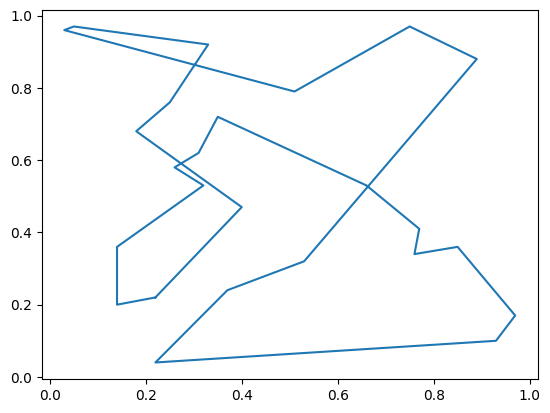

In [1343]:
plot(answer)

## 遍历算法

In [1270]:
from itertools import permutations
class TraverseTSP():
    def __init__(self,cities) -> None:
        self.cities = cities
        self.n = cities.shape[0]
        self.W = np.zeros((self.n,self.n))
        self.path = list(range(self.n))
        self.path_length = 1000000000000
        self.init_params()

    def init_params(self):
        for i in range(self.n):
            for j in range(self.n):
                self.W[i,j] = np.sqrt(np.sum((self.cities[i] - self.cities[j])**2))
    
    def cal_path_length(self,path):
        path_length = 0
        for i in range(self.n-1):
            path_length += self.W[path[i],path[i+1]]
        path_length += self.W[path[-1],path[0]]
        return path_length

    def __call__(self):
        perfect_path = self.path.copy()
        for combo in tqdm(permutations(self.path, self.n)):  # 2 for pairs, 3 for triplets, etc
            path_length = self.cal_path_length(combo)
            if path_length < self.path_length:
                self.path_length = path_length
                perfect_path = combo
        return perfect_path


## Hopfield退火算法

In [1371]:
import numpy as np
import matplotlib.pyplot as plt
class HopfieldSATSP():
    def __init__(self,cities,iterations=3000):
        self.cities = cities
        self.n = cities.shape[0]
        self.u0 = 0.02
        self.delta_t = 1e-4
        self.A = 300
        self.D = 100
        self.W = np.zeros((self.n,self.n))
        self.U = np.zeros((self.n,self.n))
        self.V = np.zeros((self.n,self.n))
        self.iter = iterations
        self.T = 50000  # initiate temperature
        self.Tmin = 10  # minimum value of terperature
        self.path_length = 1000000000000
        self.diag = np.diag(np.ones(self.n))
        self.subdiag = np.diag(np.ones(self.n-1),k=1)
        self.subdiag[-1,0] = 1
        self.onevec = np.ones((self.n,1))
        self.ones_mat = np.ones((self.n,self.n))
        self.init_params()
        

    def init_params(self,):
        for i in range(self.n):
            for j in range(self.n):
                self.W[i,j] = np.sqrt(np.sum((self.cities[i] - self.cities[j])**2))
        self.U = 1 / 2 * self.u0 * np.log(self.n - 1) + (2 * (np.random.random((self.n, self.n))) - 1)
    
    def diff(self):
        first = np.dot(self.V,self.onevec) + np.dot(self.onevec.T,self.V) -2
        second = np.dot(self.W,np.roll(self.V,-1,axis=1))
        return -self.A*first - self.D*second
        
    def get_energy(self,V):
        AAT = self.A * np.dot(V-self.diag,V.T-self.diag)
        ATA = self.A * np.dot(V.T-self.diag,V-self.diag)
        constraint = np.sum(AAT) + np.sum(ATA)
        distance_matrix = np.dot(np.dot(V.T,self.W),V)*self.subdiag
        distance = np.sum(distance_matrix)*self.D
        return 0.5 * (constraint + distance)


    
    def check(self):
        newV = np.zeros([self.n, self.n])
        route = []
        for i in range(self.n):
            mm = np.max(self.V[:, i])
            for j in range(self.n):
                if self.V[j, i] == mm:
                    newV[j, i] = 1
                    route += [j]
                    break
        return route, newV
    


    def cal_path_length(self,path):
        path_length = 0
        for i in range(self.n-1):
            path_length += self.W[path[i],path[i+1]]
        path_length += self.W[path[-1],path[0]]
        return path_length

    def __call__(self):
        for i in tqdm(range(200)):
            iter = 0
            route, newV = self.check()
            energy = 0
            delta_energy = 1
            # print(np.unique(route))
            while  delta_energy > 1e-6 and iter < self.iter:
                self.U += self.delta_t * self.diff()
                self.V = 0.5 * (1 + np.tanh(self.U / self.u0))
                temp_energy = energy
                energy = self.get_energy(self.V)
                delta_energy = abs(energy - temp_energy)
                route, newV = self.check()
                iter += 1
            route, newV = self.check()
            if len(np.unique(route)) == self.n:
                perfect_path = route
                if self.cal_path_length(perfect_path) < self.path_length:
                    self.path_length = self.cal_path_length(perfect_path)
                    V_best = self.V.copy()
                    best_path = route

            t = 0
            new_V = self.V.copy()
            new_energy = energy
            T = self.T 
            while T > self.T or t < self.iter:    
                T = self.T * 0.99**t 
                rand_scale = np.random.random([self.n,self.n])*T/self.T
                rand_scale_mat =(np.where(rand_scale > 0, 1, 0)*(self.ones_mat - new_V) + np.where(rand_scale < 0, 1, 0)*new_V)*rand_scale
                temp_V = new_V + rand_scale_mat
                temp_energy = self.get_energy(temp_V)
                if temp_energy < new_energy:
                    new_V = temp_V
                    new_energy = temp_energy
                else:
                    rand_num = np.random.random()
                    if rand_num < np.exp(-(temp_energy - new_energy)/T):
                        new_V = temp_V
                        new_energy = temp_energy
                t += 1
            self.V = new_V
            for i in range(self.n):
                for j in range(self.n):
                    self.U[i,j] = 0.5 * self.u0 * np.log(self.n-1) + np.random.random() * 2-1
    
        return best_path

## 生成城市 

In [1405]:
import random
city_x = np.random.randint(0,100,11)/100
city_y = np.random.randint(0,100,11)/100

In [1395]:
cities = np.array([city_x,city_y]).T

In [1396]:
cities

array([[0.99, 0.73],
       [0.89, 0.44],
       [0.62, 0.19],
       [0.88, 0.98],
       [0.04, 0.6 ],
       [0.  , 0.3 ],
       [0.65, 0.53],
       [0.55, 0.2 ],
       [0.3 , 0.36],
       [0.53, 0.49],
       [0.56, 0.67]])

In [1398]:
traverse_solver = TraverseTSP(cities)
traverse_perfect_path = traverse_solver()

39916800it [02:53, 229600.82it/s]


In [1399]:
hopfield_solver = HopfieldTSP(cities,iterations=100000)
energy,answer,iter = hopfield_solver()

new path length:  4.771621622406818
new path length:  3.6080535312120126
new path length:  3.4507984317400924
new path length:  3.4189215130860653
new path length:  3.2779671740536345


In [1400]:
hopfield_SA_solver = HopfieldSATSP(cities)
perfect_path= hopfield_SA_solver()

100%|██████████| 200/200 [02:26<00:00,  1.37it/s]


In [1401]:
def plot(path_list):
    cities_list = cities.tolist()
    cities_plot_list = []
    for item in path_list:
        cities_plot_list.append(cities_list[item])
    cities_plot_list.append(cities_list[path_list[0]])
    plt.plot(*np.array(cities_plot_list).T)
    plt.show()


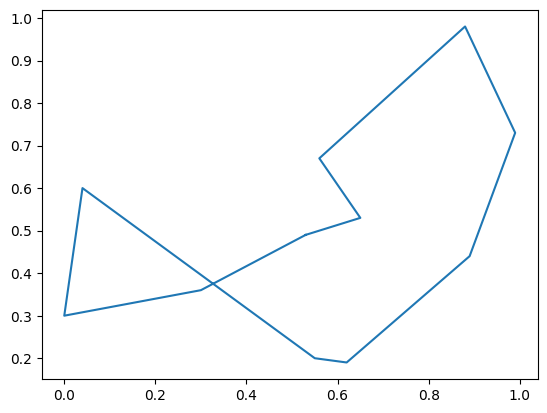

In [1402]:
plot(answer)

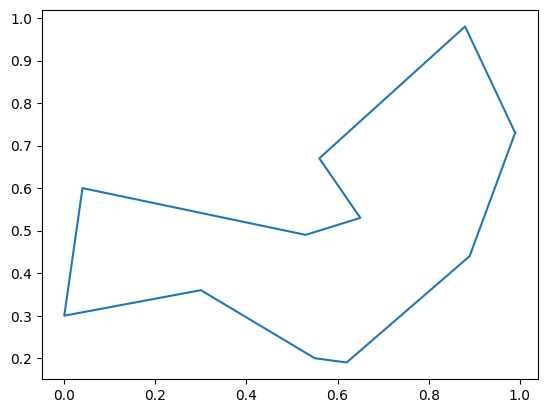

In [1403]:
plot(traverse_perfect_path)

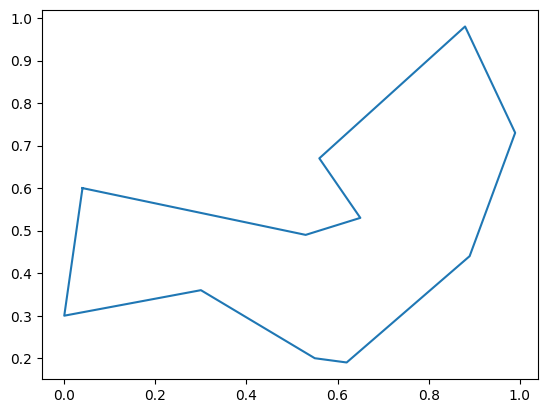

In [1404]:
plot(perfect_path)